Hacemos una EDA para ver el comportamiento de las variables y sus relaciones para ver como afectan a otras y tambien como afectan la variable target que es aqui si un cliente ha suscrito a un deposito a plazo.

Mi codigo es el mio o puede venir de:\
\
un github de youtubers (los dos que utilizo son https://github.com/LeCoinStat/ y https://github.com/codebasics/)\
\
De tu codigo de EDA\
\
He utilizado chatgpt para crear algun diseno y he cambiado muchas cosas del codigo de chatgpt para personalizarlo o adaptarlo bien a esta EDA.

# LIBRAIRIES

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
from scipy.stats import zscore, f_oneway
from scipy.stats import ttest_ind
from sklearn.feature_selection import mutual_info_classif
import missingno as msno
from sklearn.preprocessing import TargetEncoder, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [3]:
ruta=r"..\data\fin_mark_full_mod.csv"
df_raw=pd.read_csv(ruta,sep=";")
df_raw.shape

(41188, 21)

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41093 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Vamos a cambiar el tipo de algunas de variables porque no estan bien hechas (ej: is_suscribed in object, nr.employed in object)

In [5]:
df_raw['is_suscribed'] = df_raw['is_suscribed'].astype('object')
df_raw['nr.employed'] = df_raw['nr.employed'].astype('object')

In [6]:
df_raw.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1     -1         0  nonexistent          1.1   
1   may         mon  ...         1     -1         0  nonexistent          1.1   
2   may         mon  ...         1     -1         0  nonexistent          1.1   
3   may         mon  ...         1     -1         0  nonexistent          1.1   
4   may         mon  ...         1     -1         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed is_suscribed  
0          93.994          -36.4      4.857       5191.0            0  
1          93.994          -36.4      4.857       5191.0            0  
2          93.994          -36.4      4.857       5191.0            0  
3          93.994          -36.4      4.857       5191.0            0  
4          93.994          -36.4      4.857       5191.0            0  

[5 rows x 21 columns]

In [7]:
df_raw.isnull().sum()[df_raw.isnull().sum()>0].sort_values(ascending=False)

housing         990
loan            990
emp.var.rate     95
euribor3m        60
dtype: int64

Tenemos nulos que tratar y tambien tendremos que aprofundizar la variable marital porque parece que tenemos nulos pero no sabemos como estan registrados.

In [8]:
df_raw.duplicated().sum()

np.int64(12)

Tenemos duplicados que vamos a eliminar

In [9]:
df_raw.drop_duplicates(inplace=True)
df_raw.shape

(41176, 21)

In [10]:
numeric_cols = [col for col in df_raw.columns if df_raw[col].dtype in ['int64', 'float64']]
str_cols = [col for col in df_raw.columns if df_raw[col].dtype == 'object']
print(f"Numeric columns: {numeric_cols}")
print(f"String columns: {str_cols}")

Numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
String columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'nr.employed', 'is_suscribed']


# ANALISIS UNIVARIANTE

In [11]:
for col in df_raw.columns:
    value_counts = df_raw[col].value_counts().head(10)
    percentage = round(value_counts/df_raw.shape[0] * 100,2)
    print("\033[1m\033[4m" + col + "\033[0m")
    print(pd.DataFrame({'Valeur': value_counts.index, 'Nombre': value_counts.values, 'Pourcentage': percentage.values}))
    print(f"Type {df_raw[col].dtype}")
    print("-----------------------------")

age
   Valeur  Nombre  Pourcentage
0      31    1947         4.73
1      32    1845         4.48
2      33    1833         4.45
3      36    1779         4.32
4      35    1758         4.27
5      34    1745         4.24
6      30    1714         4.16
7      37    1475         3.58
8      29    1453         3.53
9      39    1430         3.47
Type int64
-----------------------------
job
          Valeur  Nombre  Pourcentage
0         admin.   10419        25.30
1    blue-collar    9253        22.47
2     technician    6739        16.37
3       services    3967         9.63
4     management    2924         7.10
5        retired    1718         4.17
6   entrepreneur    1456         3.54
7  self-employed    1421         3.45
8      housemaid    1060         2.57
9     unemployed    1014         2.46
Type object
-----------------------------
marital
     Valeur  Nombre  Pourcentage
0   married   24921        60.52
1    single   11564        28.08
2  divorced    4611        11.20
3   unknow

Sobre la variable marital tenemos 80 'unknown' que podemos afectar como NaN o simplemente cambiar por la moda. Tenemos el mismo problema sobre la education y tambien default pero no vamos a imputar default porque los unknowns representan 20%\
Por la variable target, vemos que tenemos una menor populacion de personas que han suscrito a un deposito a plazo (11%). se puede afectar el modelo mas tarde (pensar en un undersampling y bien hacer la estratificacion).

## QUANTITATIVE

In [12]:
df_raw[numeric_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]).T.style.background_gradient(cmap='coolwarm')

Parece con este visual que tenemos outliers porque tenemos valores atypicas en duration, campain, pdays, previous porque hay una gran diferencia entre el percentil 95% y 99% y el maximo. Tenemos que hacer una visualizacion para ver esto mas en detalle.

In [13]:
df_raw[numeric_cols].skew().sort_values(ascending=False)

pdays             7.321257
campaign          4.762044
previous          3.831396
duration          3.262808
age               0.784560
cons.conf.idx     0.302876
cons.price.idx   -0.230853
euribor3m        -0.708753
emp.var.rate     -0.723334
dtype: float64

In [14]:
df_raw[numeric_cols].kurt().sort_values(ascending=False)

pdays             63.983160
campaign          36.971857
duration          20.243771
previous          20.102164
age                0.791113
cons.conf.idx     -0.359097
cons.price.idx    -0.829851
emp.var.rate      -1.063640
euribor3m         -1.407414
dtype: float64

Parece que tenemos variables con distribucion con no tan asymetria (exepto pdays que tiene una gran cola a la derecha) y tenemos algunas con un gran curtosis como pdays y campain asi parece que hay picos. Con esta analysis, confirmamos que tenemos grand colas a la derecha con pdays, duration, campain y previous.

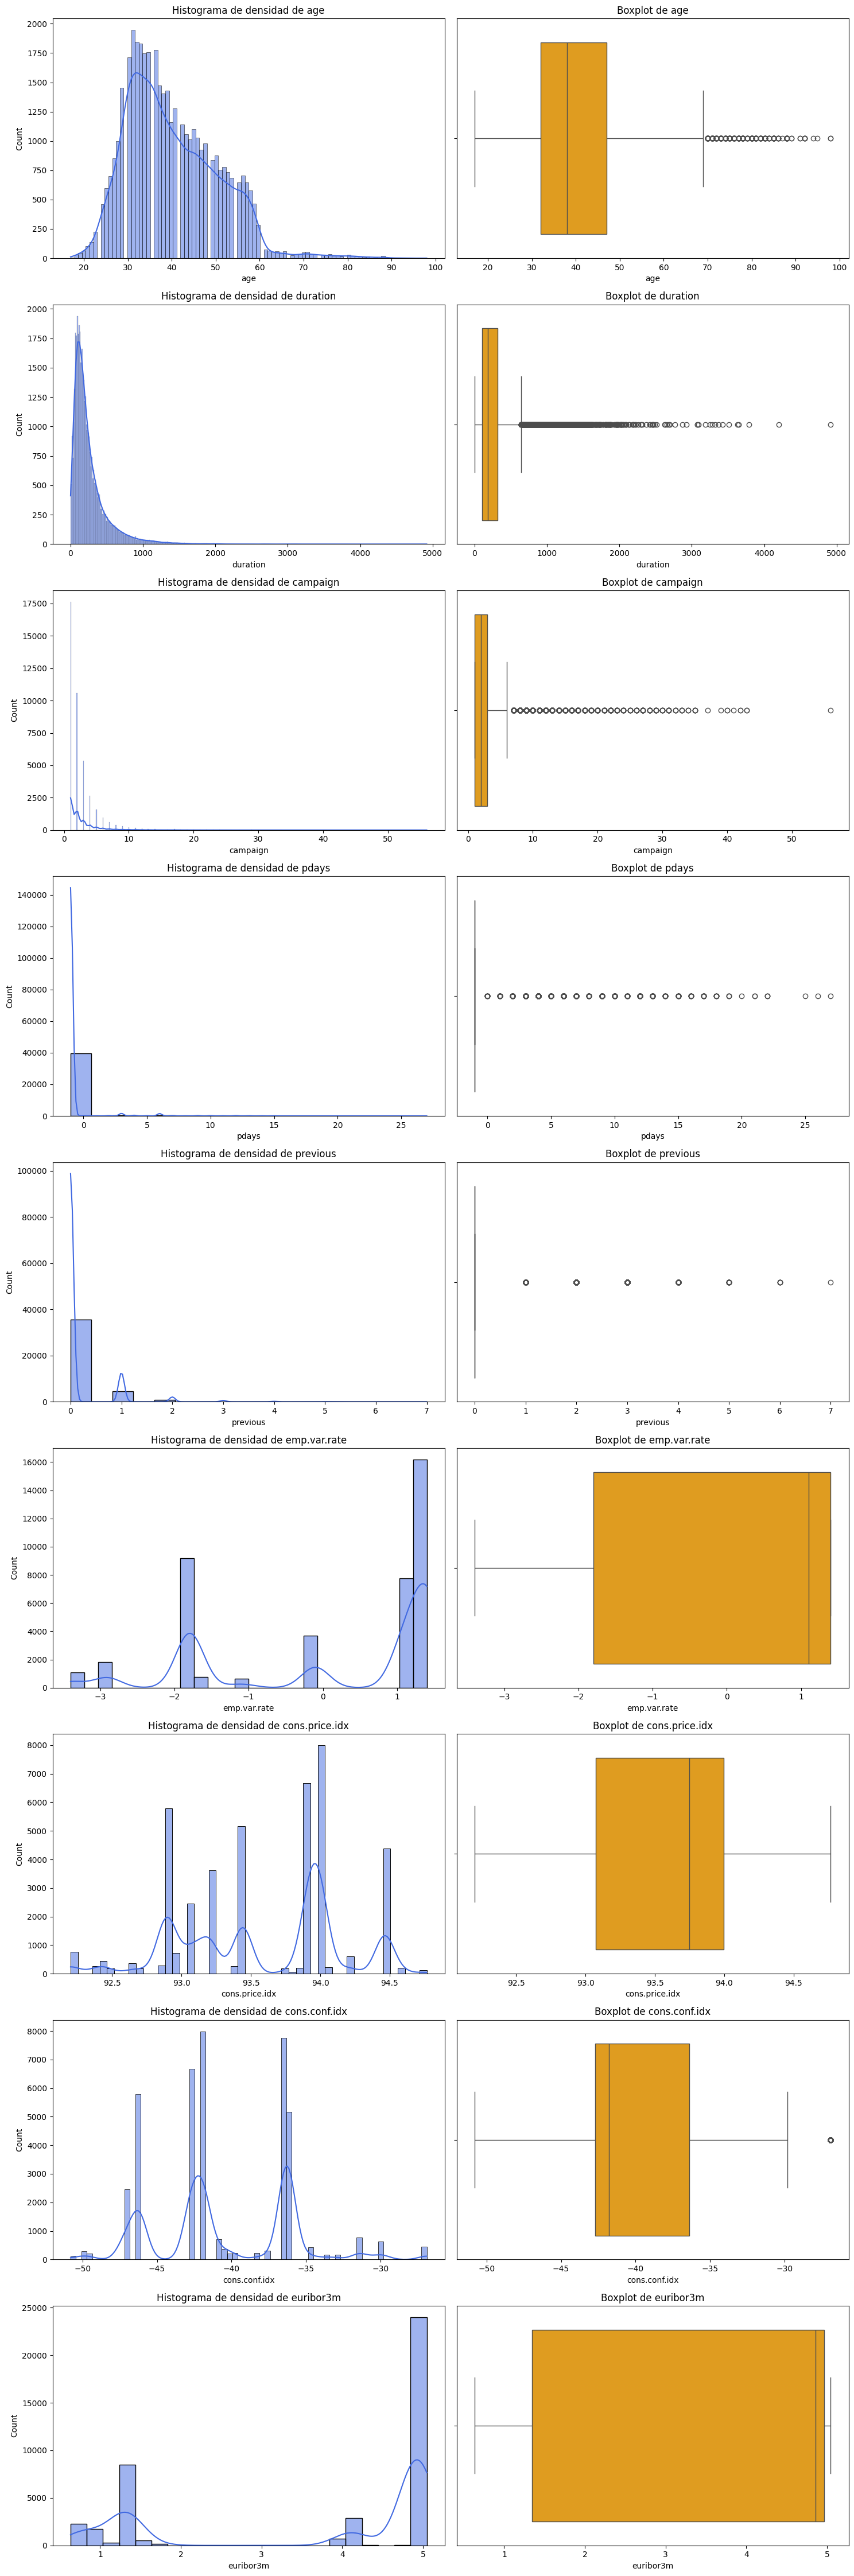

In [15]:
fig, axes = plt.subplots(nrows=len(df_raw[numeric_cols].columns), ncols=2, figsize=(15, 5 * len(df_raw[numeric_cols].columns)))

for i, column in enumerate(df_raw[numeric_cols]):
   
    sns.histplot(df_raw[column], kde=True, ax=axes[i, 0], color='royalblue')
    axes[i, 0].set_title(f'Histograma de densidad de {column}')
    
    
    sns.boxplot(x=df_raw[column], ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Boxplot de {column}')



plt.tight_layout()
plt.show()

Podemos aplicar una transformacion sobre la duration porque tenemos una grand cola.

<Axes: xlabel='duration', ylabel='Count'>

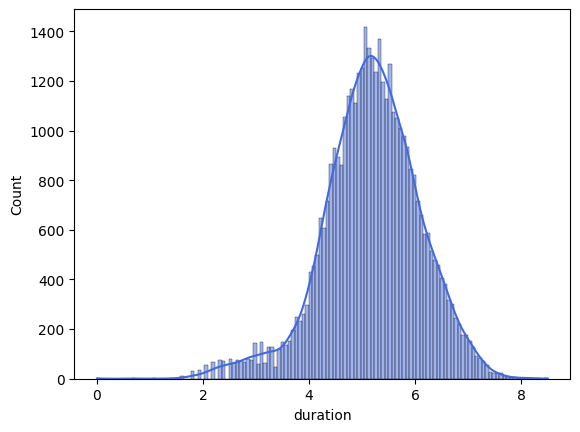

In [16]:
Duration_log = np.log(df_raw["duration"]+1)
sns.histplot(Duration_log, kde=True, color='royalblue')

Con la aplicacion del logaritmo parece que tenemos una mejor distribucion (normal) de la variable duration. Es que tenemos una gran concentracion a la media. 

In [17]:
#chatgpt para el IQR pero yo para el 90% y el 95%
def outlier_metrics(df, quant_vars):
    results = {}
    total = df.shape[0]
    for col in quant_vars:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_threshold = Q3 + 1.5 * IQR
        percentile_95 = df[col].quantile(0.95)
        percentile_90 = df[col].quantile(0.90)

        pct_above_IQR = (df[col] > upper_threshold).mean() * 100
        pct_above_95 = (df[col] > percentile_95).mean() * 100
        pct_above_90 = (df[col] > percentile_90).mean() * 100

        results[col] = {
            "Q3 + 1.5IQR": upper_threshold,
            "% > Q3 + 1.5IQR": round(pct_above_IQR, 2),
            "P95": percentile_95,
            "% > P95": round(pct_above_95, 2),
            "P90": percentile_90,
            "% > P90": round(pct_above_90, 2)
        }
    
    return pd.DataFrame.from_dict(results, orient='index')

metrics_df = outlier_metrics(df_raw, numeric_cols)
print(metrics_df)


                Q3 + 1.5IQR  % > Q3 + 1.5IQR      P95  % > P95      P90  \
age                 69.5000             1.14   58.000     4.02   55.000   
duration           644.5000             7.20  753.000     4.98  551.000   
campaign             6.0000             5.84    7.000     4.32    5.000   
pdays               -1.0000             3.68   -1.000     3.68   -1.000   
previous             0.0000            13.66    1.000     2.58    1.000   
emp.var.rate         6.2000             0.00    1.400     0.00    1.400   
cons.price.idx      95.3725             0.00   94.465     0.81   94.465   
cons.conf.idx      -26.9500             1.08  -33.600     4.89  -36.100   
euribor3m           10.3865             0.00    4.966     4.41    4.964   

                % > P90  
age                8.70  
duration           9.97  
campaign           8.22  
pdays              3.68  
previous           2.58  
emp.var.rate       0.00  
cons.price.idx     0.81  
cons.conf.idx      6.38  
euribor3m      

Asi, con la analysis visual y de las metricas, podemos ver las distribuciones de las variables y parece que no hay distribucion normal. Podemos ver muchos outliers pero mucho de ellos pueden ser realisto como la duration, la campain y el edad. Nos falta juicio experto para decidir del tratamiento de esos outliers pero en mi caso, en primer lugar, vamos a hacer una windsorisacion a 95% porque es lo que me parece lo mas sencillo aqui para no perder informaciones. Con esta tecnica perdemos menos de 5% de las informaciones.

## QUALITATIVE

In [18]:
df_raw[str_cols].describe().T

count unique                top     freq
job             41176     12             admin.    10419
marital         41176      4            married    24921
education       41176      8  university.degree    12164
default         41176      3                 no    32577
housing         40186      2                yes    21571
loan            40186      2                 no    33938
contact         41176      2           cellular    26135
month           41176     10                may    13767
day_of_week     41176      5                thu     8618
poutcome        41176      3        nonexistent    35551
nr.employed   41176.0   11.0             5228.1  16228.0
is_suscribed    41176      2                  0    36537

Con este se puede ver nuestro cliente de refenrencia. Podremos, con analisis futuro, cual es el mejor dia para maximizar una venta y tambien que mes. Podremos analizar tambien la importancia del movil.

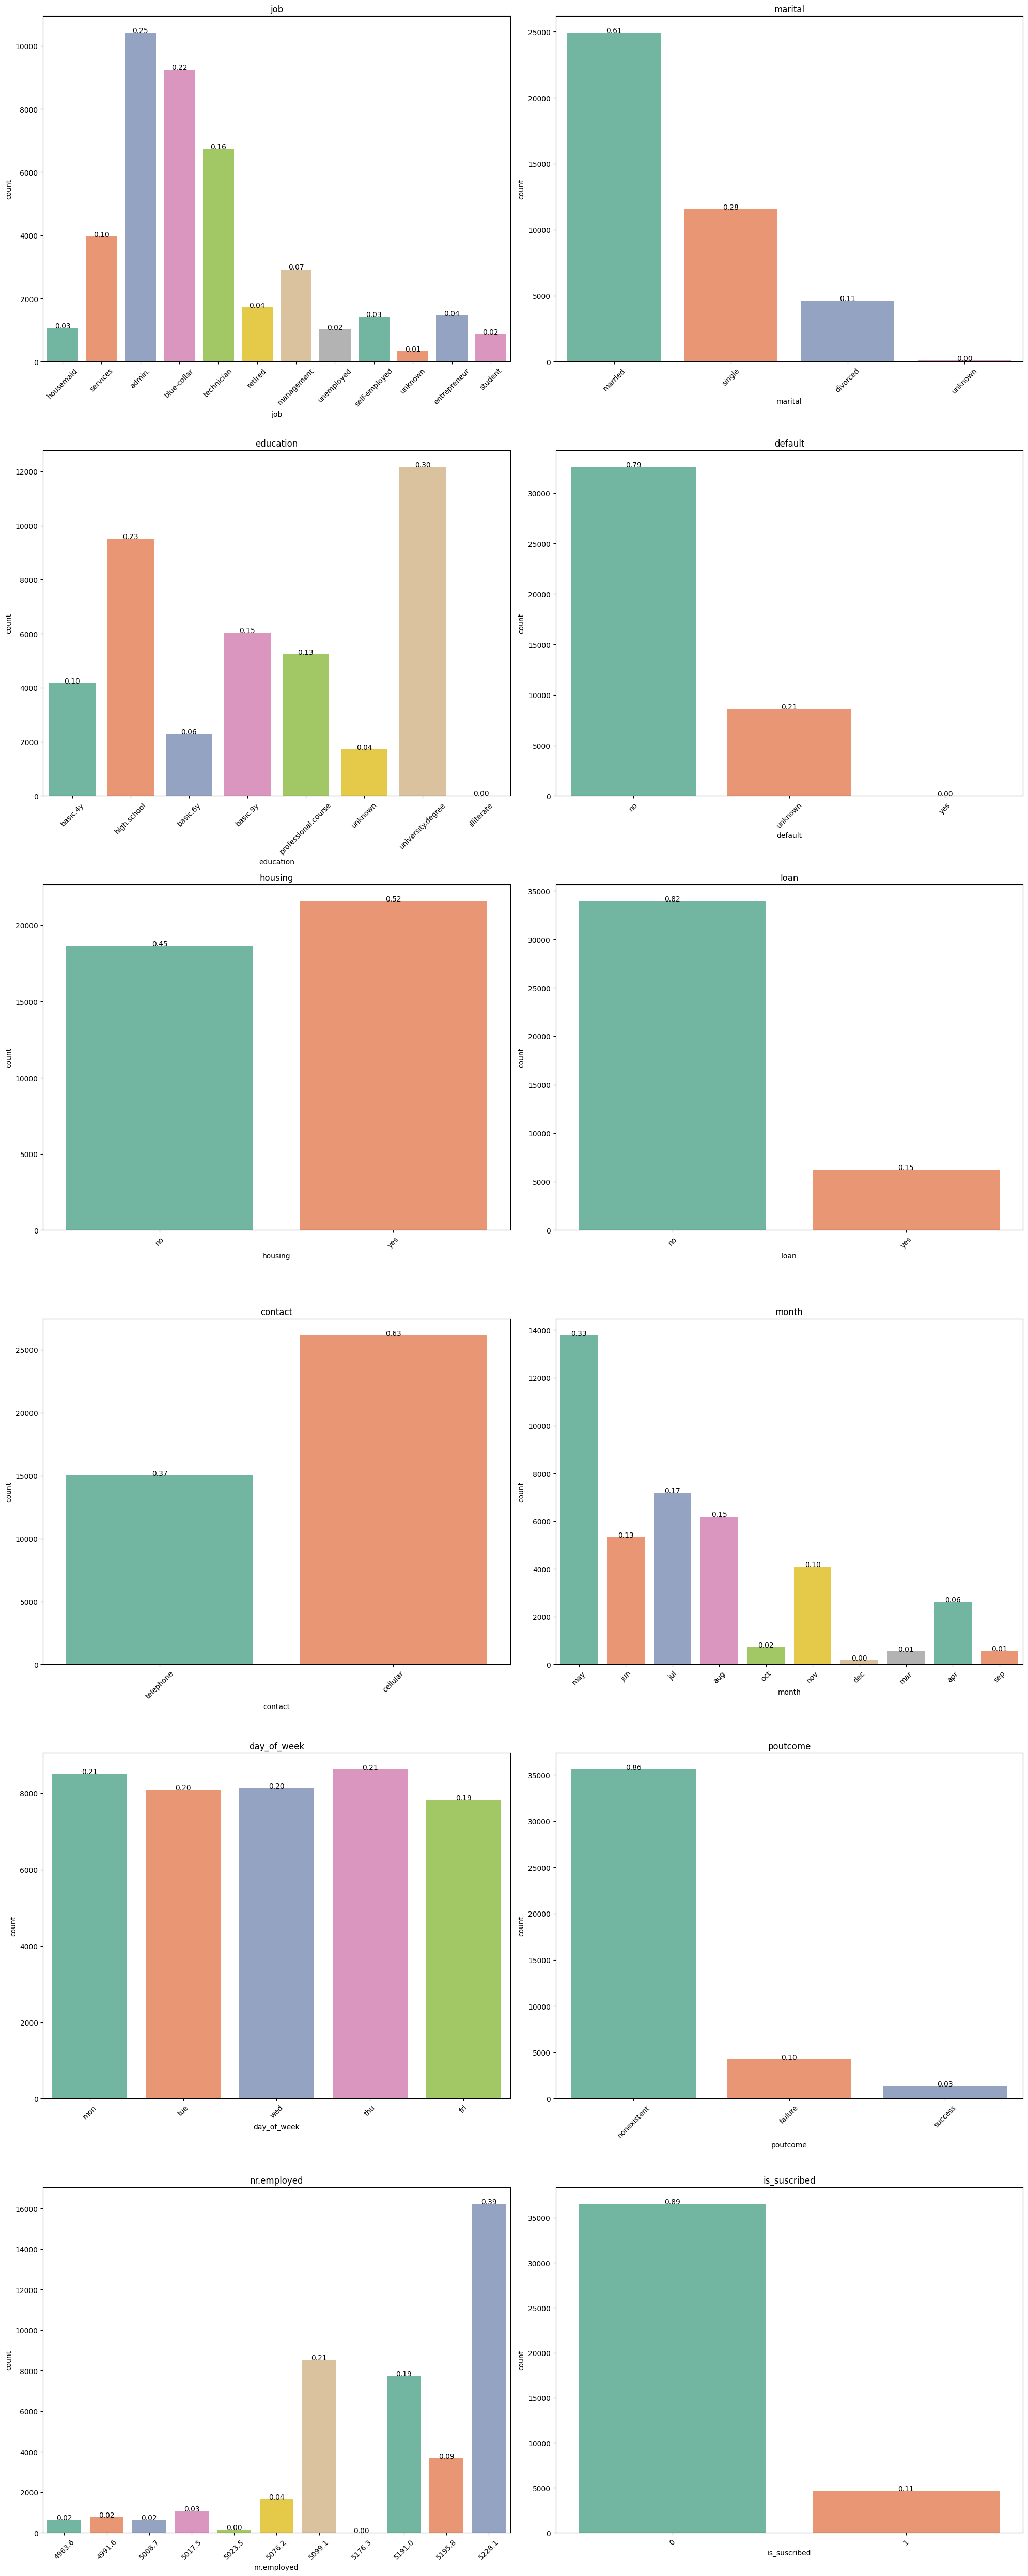

In [19]:
#chat gpt solo para ayudarme a poner los porcentajes
plt.figure(figsize=(20,50))


for i, var in enumerate(str_cols):
    plt.subplot(len(str_cols)//2, 2, i+1)
    ax = sns.countplot(data=df_raw, x=var, palette="Set2")
    plt.title(var)
    plt.xticks(rotation=45)
    
    total = float(len(df_raw))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}'.format(height/total),
                ha="center") 


plt.tight_layout()
plt.show()

Tenemos algunos unknown en la educacion, el defecto y el job. Podremos imputar por la mediana por el job y la educacion porque cada uno representa menos de 0.01% y 0.04% respectivamente.\
Pero para el defecto es un poquito mas complicado porque representan 20% de la variable y no quiero imputar por el momento para no perder informaciones o para no crear ruido. Una tecnica possible aqui es imputar de manera iterativa o con el KNN para ver si mejora el modelo predictivo o no. Tambien, tenemos 0% de si sobre esta variable asi podemos quitarla.

# ANALISIS BIVARIATE

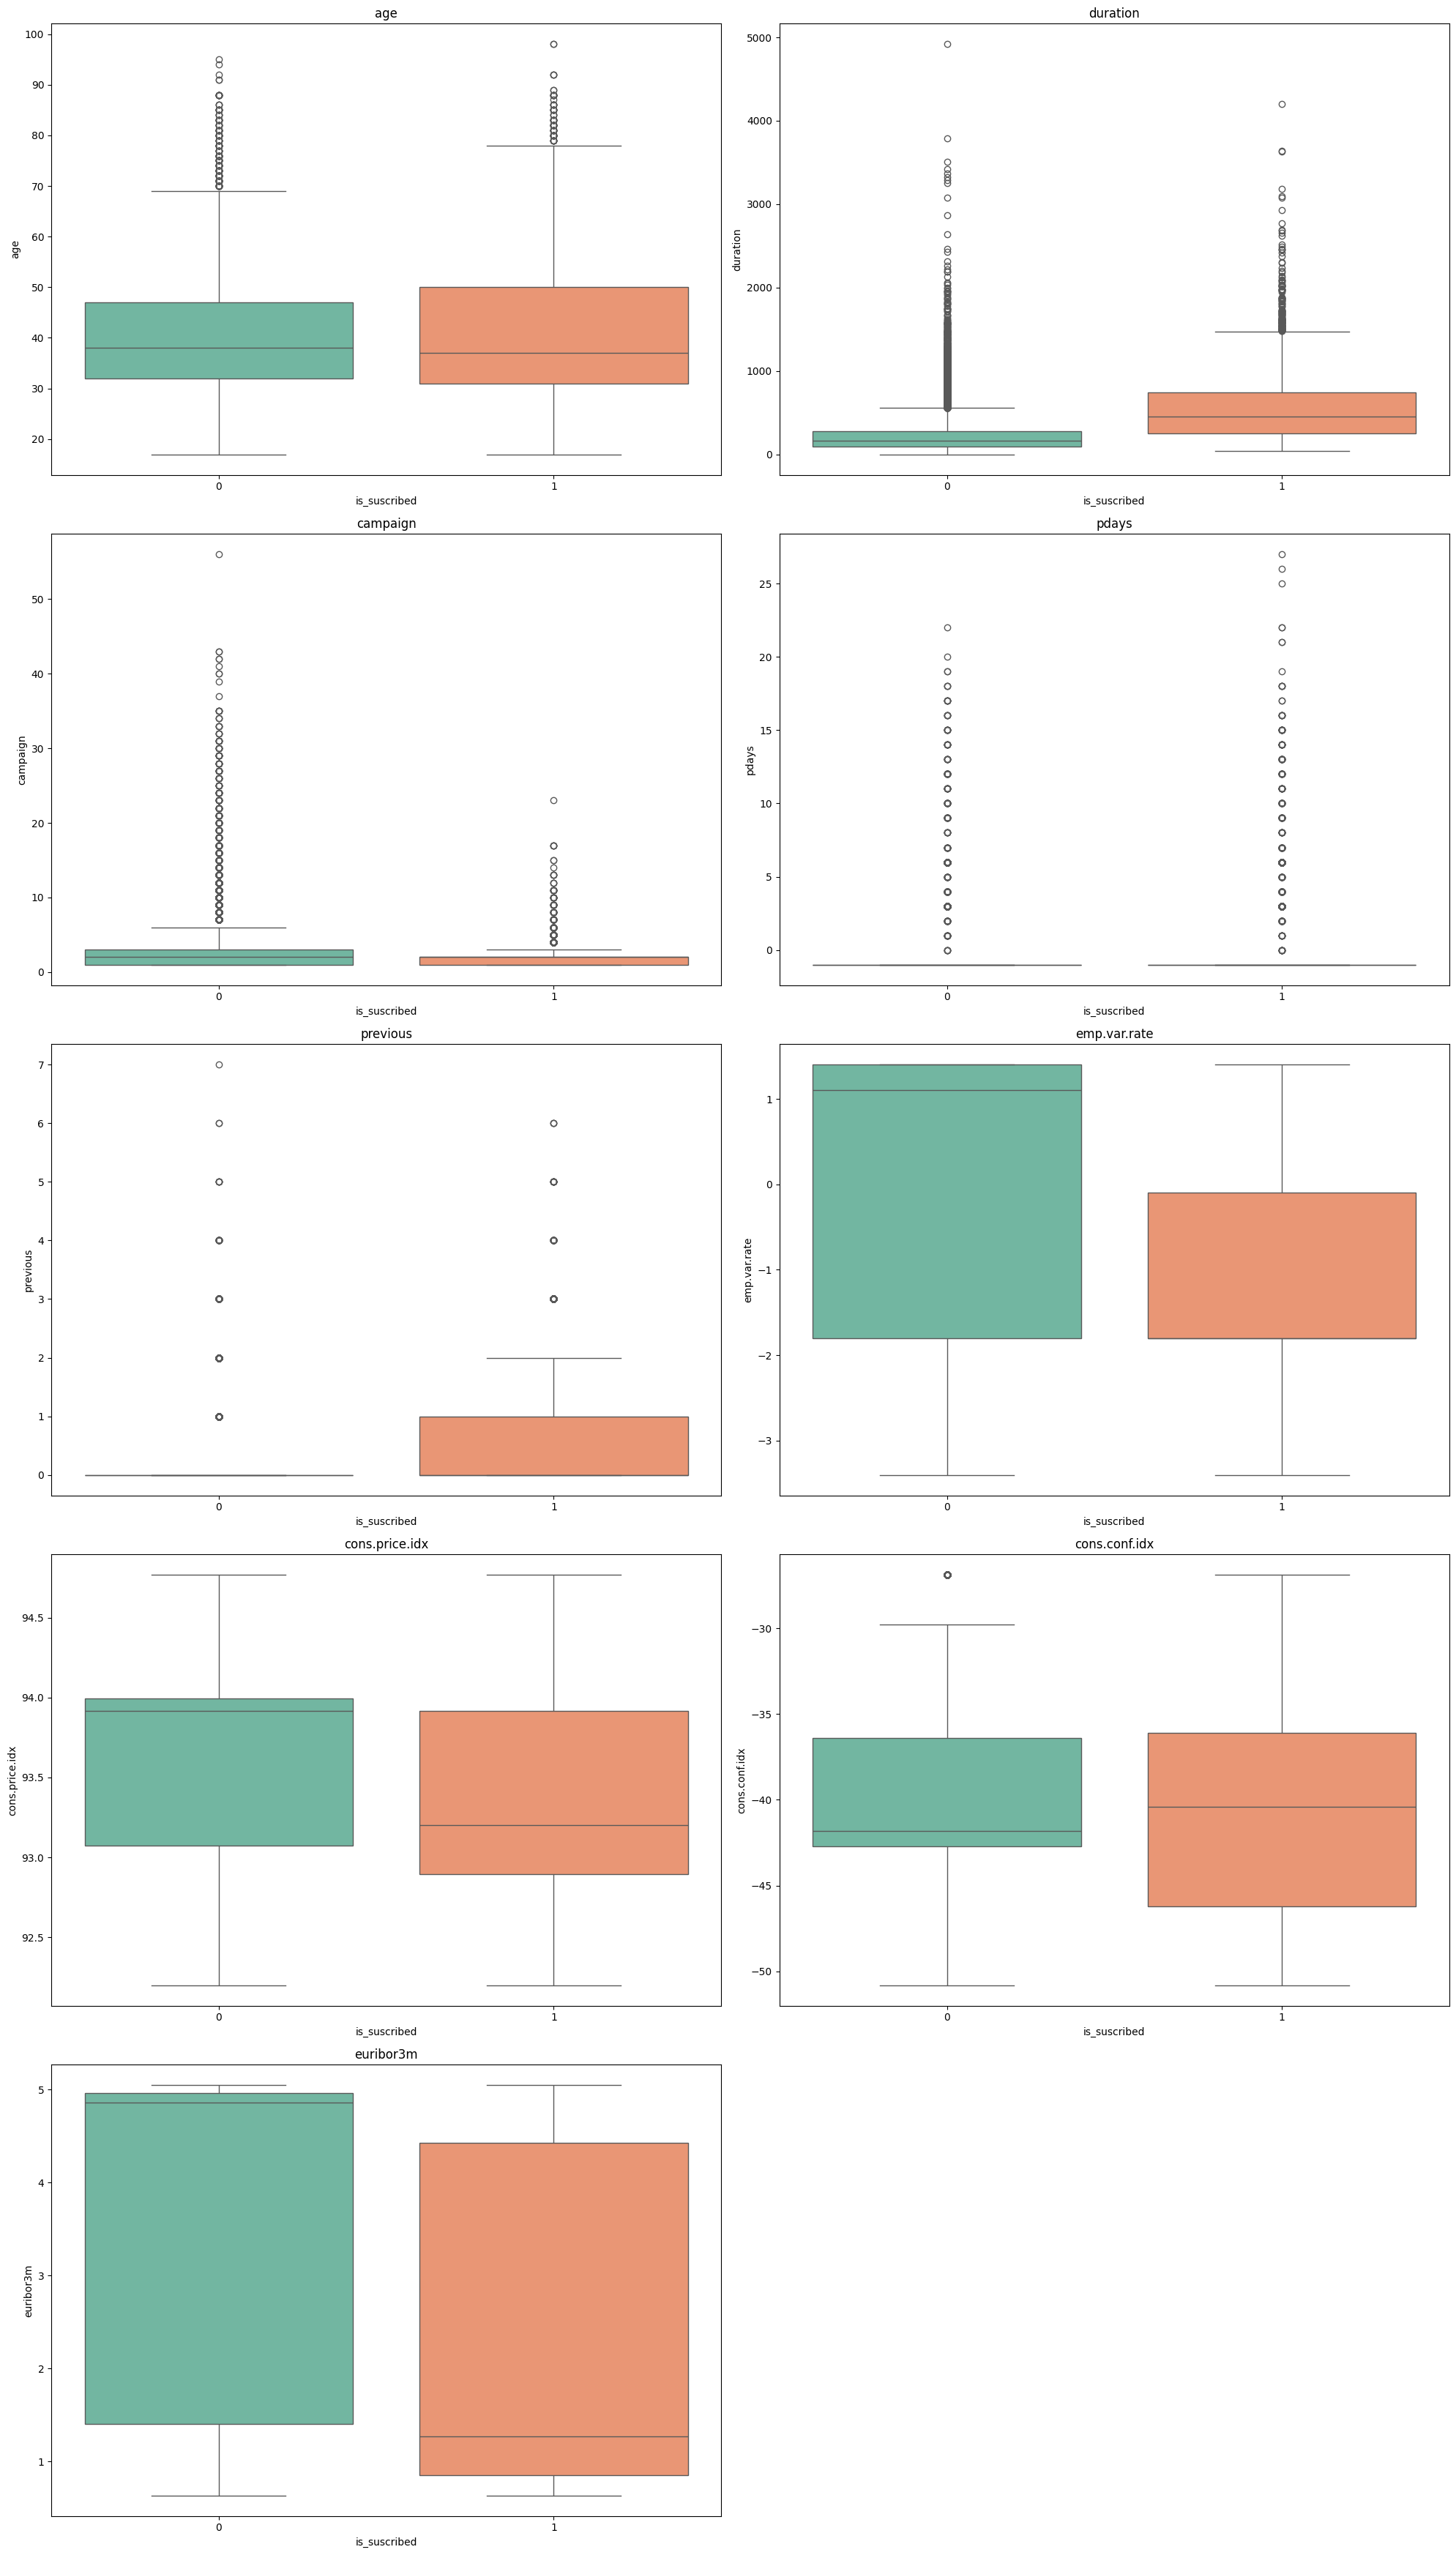

In [ ]:

plt.figure(figsize=(20,35))


for i, var in enumerate(numeric_cols):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data = df_raw, x = 'is_suscribed', y = var, palette="Set2")
    plt.title(var)


plt.tight_layout()
plt.show()

Con esta visualizacion, lo que podemos ver es que cuanto mas una llamada dura, hay mas suerte de firmar un deposito a plazo. Podemos ver tambien la importancia de los contactos realizado antes de la campana para obtener una firma. 

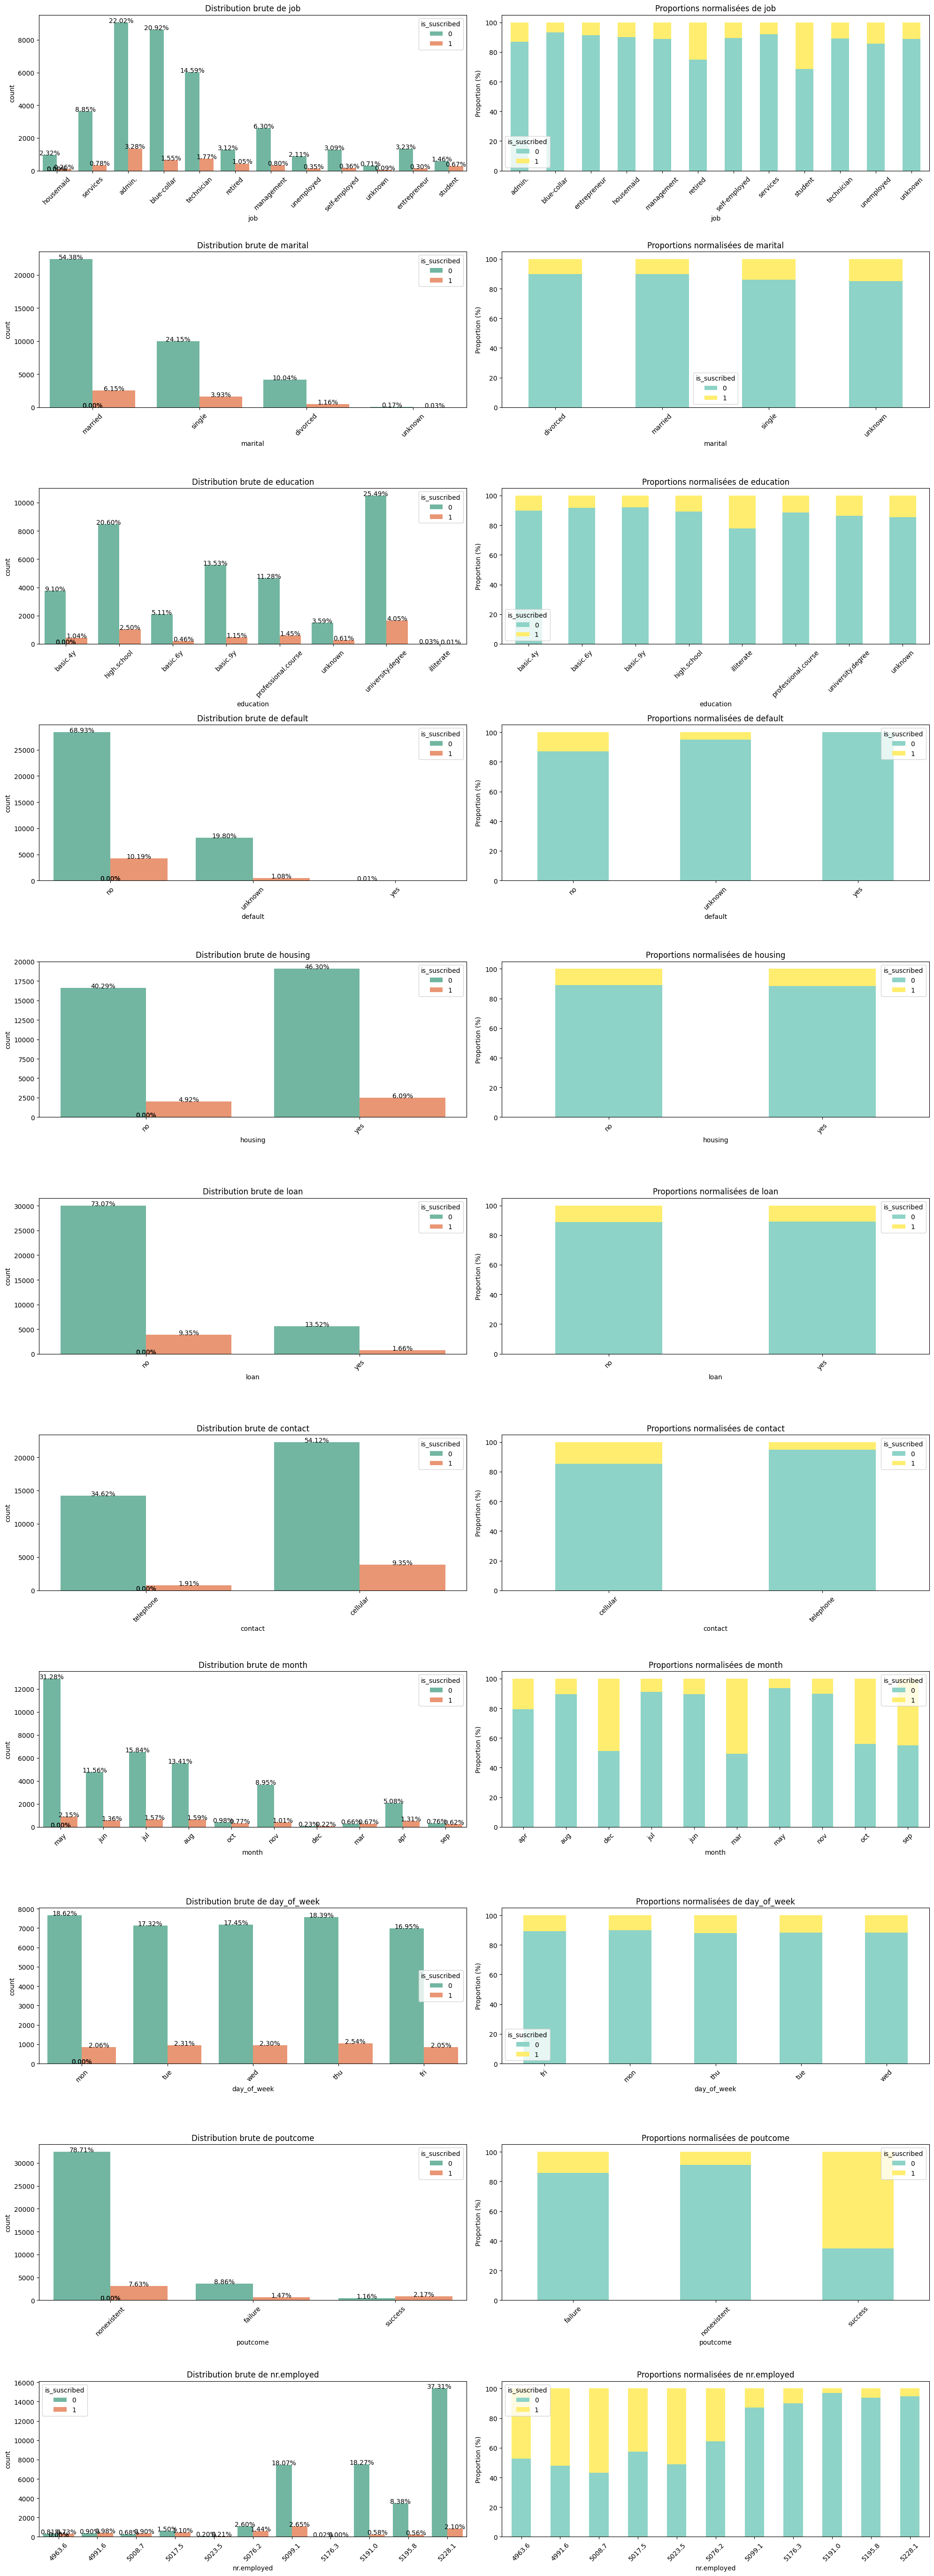

In [ ]:

strg_cols_without_target = [col for col in str_cols if col != 'is_suscribed']


n = len(strg_cols_without_target)

#me inspiro de tu codigo y usé chatgpt para darme los porcentages y la parte derecha de los graficos

fig, axes = plt.subplots(n, 2, figsize=(20, n * 5))  

for i, var in enumerate(strg_cols_without_target):
    
    ax1 = axes[i, 0] if n > 1 else axes[0] 
    sns.countplot(data=df_raw, x=var, hue='is_suscribed', palette="Set2", ax=ax1)
    
   
    total = len(df_raw)
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x() + p.get_width() / 2., height + 3, f'{height / total:.2%}', ha="center")

    ax1.set_title(f"Distribution brute de {var}")
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

    
    ax2 = axes[i, 1] if n > 1 else axes[1] 
    crosstab = pd.crosstab(df_raw[var], df_raw["is_suscribed"], normalize="index") * 100
    crosstab.plot(kind="bar", stacked=True, colormap="Set3", ax=ax2)

    ax2.set_title(f"Proportions normalisées de {var}")
    ax2.set_ylabel("Proportion (%)")
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


Tenemos muchas informaciones diferentes aqui. Son los clientes con un puesto de adminitrador que hacen los mas suscripción. En porcentage de la clase de job, son los estudiantes y los jubilados que hacen una suscripción.\
No vemos diferencia con el status marital, de educacion (los iiliterates son los con la mayor propension a hacer una suscripción). \
Podemos ver tambien que las personas sin defectuo han una mayor propension a la suscripción. \
No parece haber un mejor dia. Por los meses, el mes de mayo es el mas importante pero con una propension muy debil frente a diciembre, marzo y octubre.\
Parece que las llamadas al cellular tienen mas suerte.\
Las campanas previas con exitos parece tener mas suerte.\
Y por fin, hay empleos muy efficiente frente a la cantidad de sus llamadas como el caso del empleado 5508.7 frente al 5228.1.

# PROPROCESSING

In [20]:
df_clean = df_raw.copy()

## MISSING VALUES

Ahora podemos tratar los nulos. Sabemos que en marital y education hay unknowns.

In [21]:
#tu codigo
df_missing = df_clean.isnull().sum()
df_missing = df_missing[df_missing > 0]
df_missing = df_missing.reset_index()


df_missing['percentage'] = df_missing[0] / len(df_clean) * 100
df_missing

index    0  percentage
0       housing  990    2.404313
1          loan  990    2.404313
2  emp.var.rate   95    0.230717
3     euribor3m   60    0.145716

Vamos a imputar los nulos de euribor3m, emp.var.rate con la mediana y loan, housing, marital y education con la moda. Imputamos porque cada uno representan menos de 3% de las variables.

In [22]:
df_clean['housing'].fillna(df_clean['housing'].mode()[0], inplace=True)
df_clean['loan'].fillna(df_clean['loan'].mode()[0], inplace=True)
df_clean['marital'] = df_clean['marital'].replace('unknown', df_clean['marital'].mode()[0])
df_clean['education'] = df_clean['education'].replace('unknown', df_clean['education'].mode()[0])

df_clean['emp.var.rate'].fillna(df_clean['emp.var.rate'].median(), inplace=True)
df_clean['euribor3m'].fillna(df_clean['euribor3m'].median(), inplace=True)

In [23]:
df_clean.isnull().sum()[df_clean.isnull().sum()>0].sort_values(ascending=False)

Series([], dtype: int64)

## OUTLIERS

In [24]:
#tu codigo
def windsorize_upper(df, columns, upper_percentile=0.95):
    """
    Windsorize the upper tail of a series at a given percentile.
    """
    for col in columns:
        upper_limit = df[col].quantile(upper_percentile)
        df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])
    return df

df_clean = windsorize_upper(df_clean, numeric_cols)

In [25]:
df_clean[numeric_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]).T.style.background_gradient(cmap='coolwarm')

# ANALYSIS MULTIVARIATE

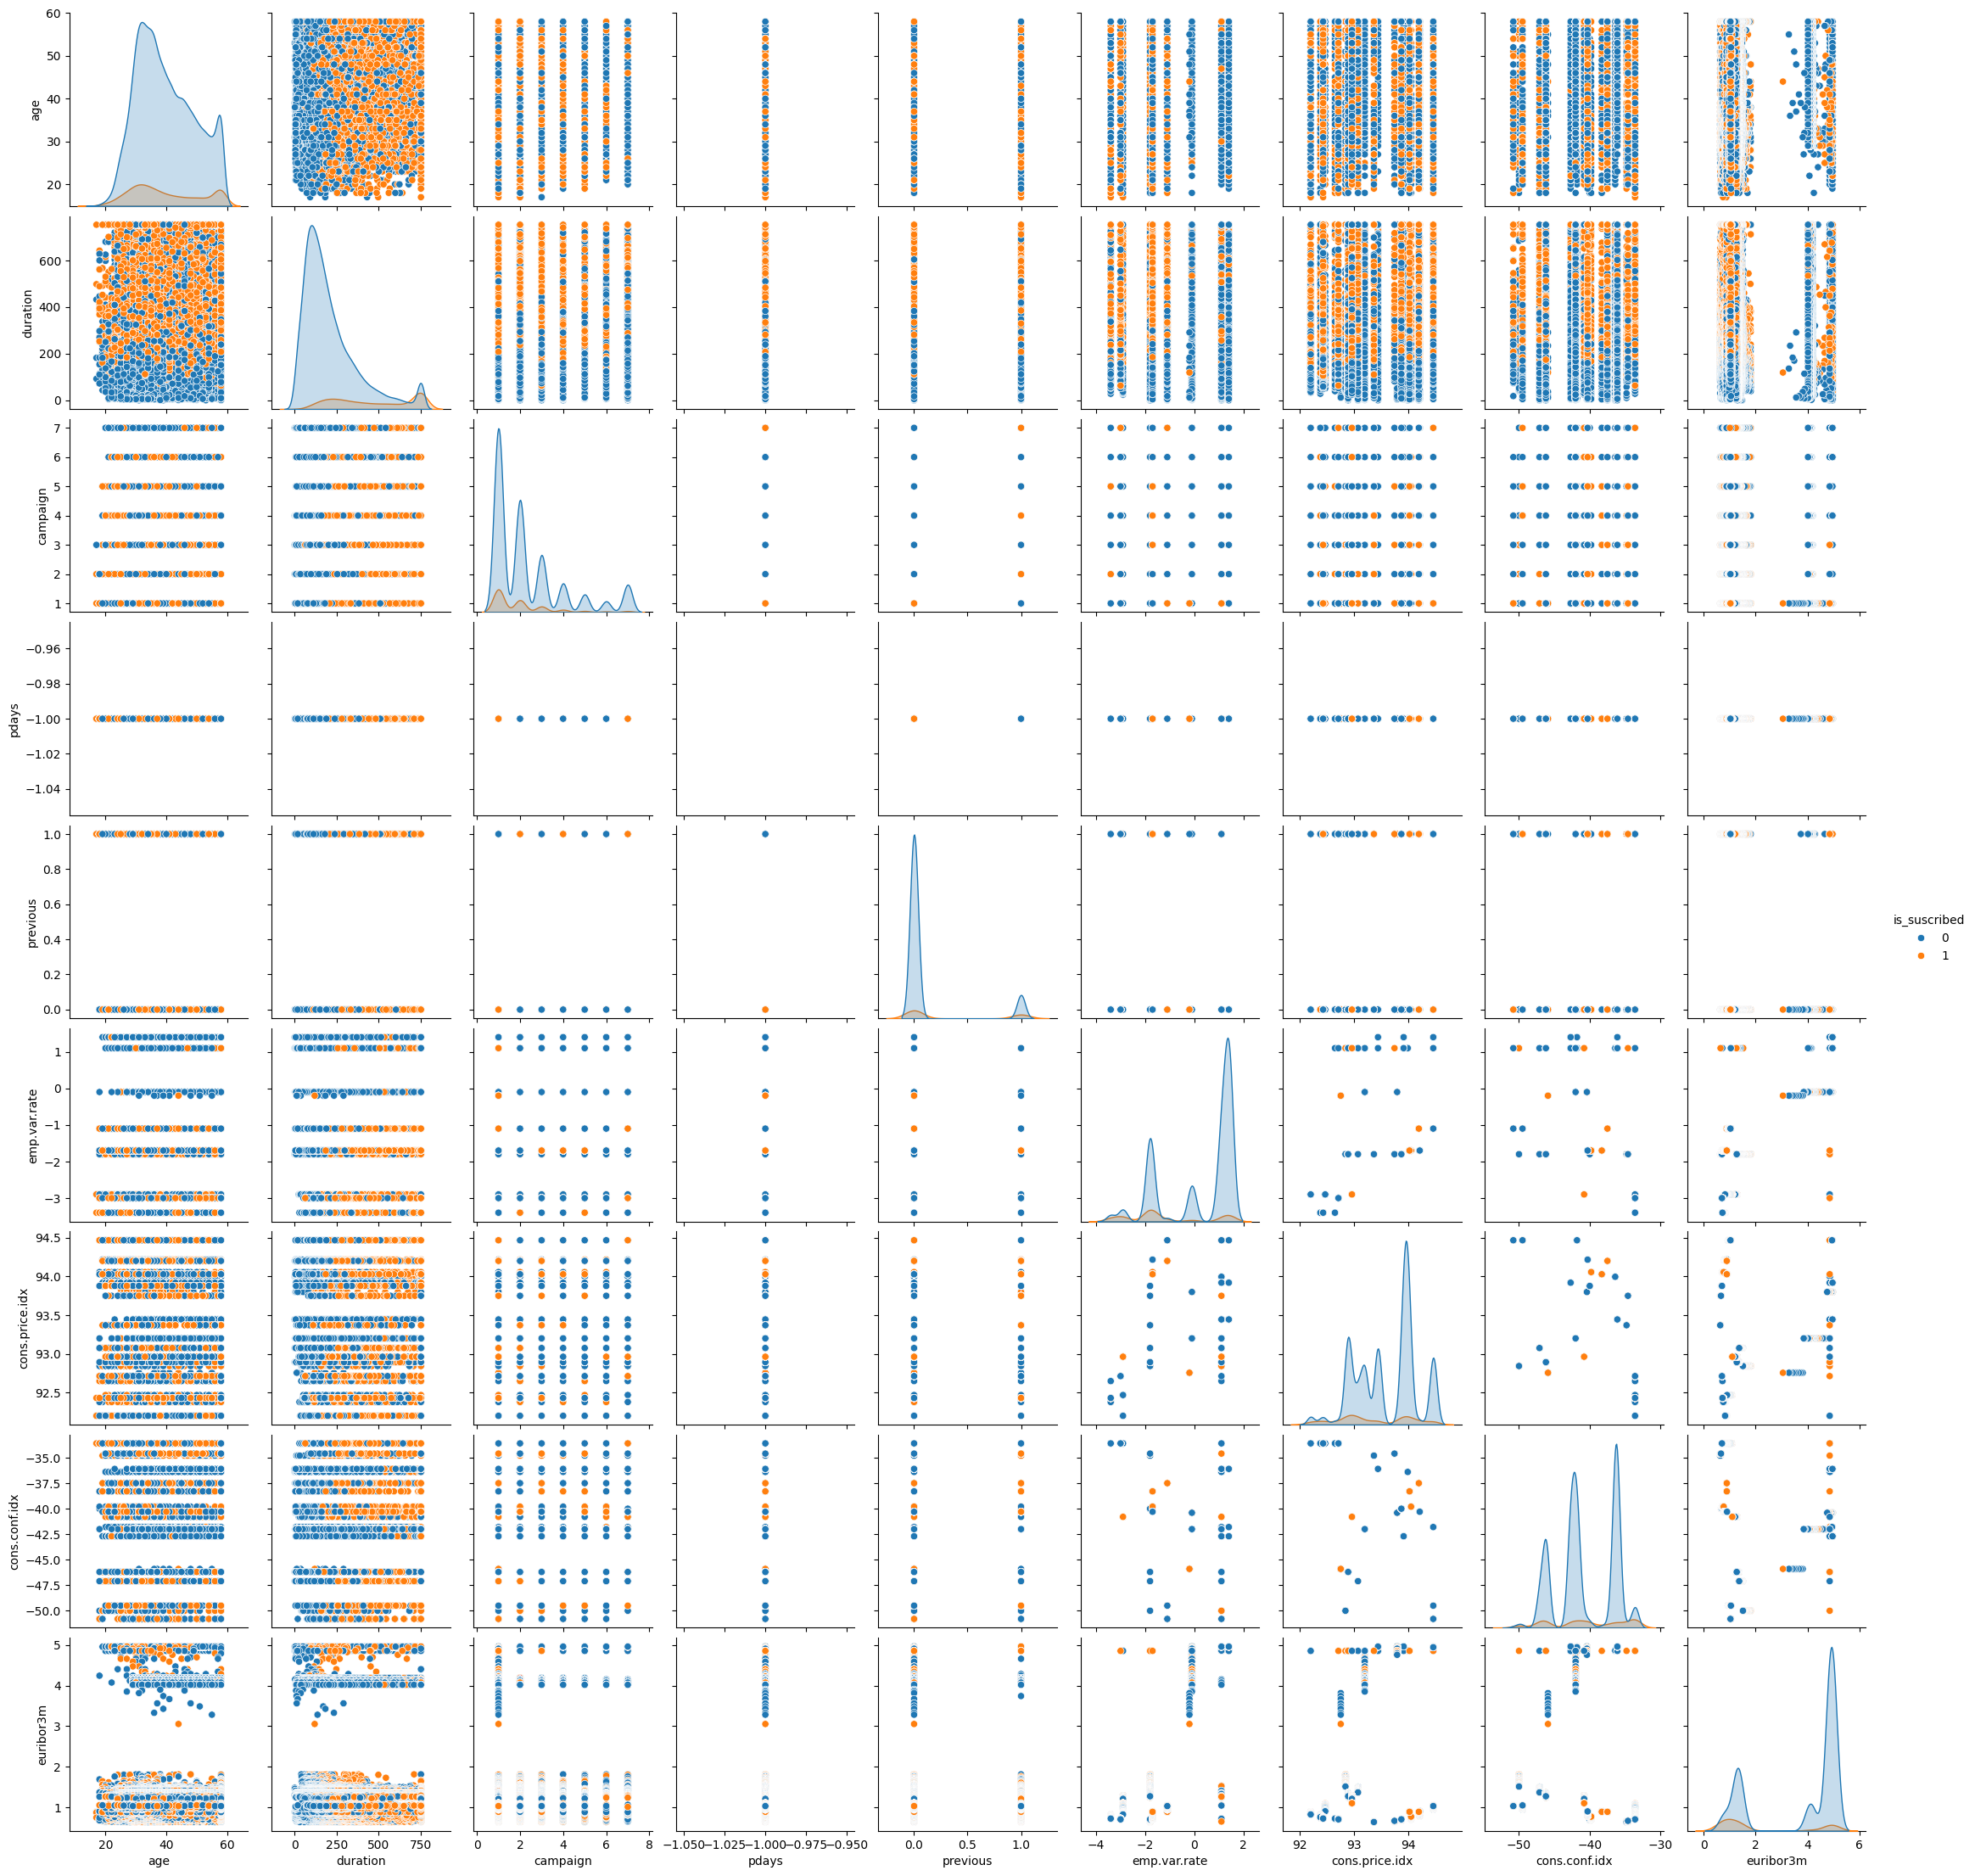

In [ ]:
df_clean['is_suscribed'] = df_clean['is_suscribed'].astype(object)
sns.pairplot(df_clean[numeric_cols + ['is_suscribed']], diag_kind='kde', hue='is_suscribed')
plt.show()

No tenemos mucha informacion importante aqui. Podemos ver de nuevo que las suscripciones se realicen a partir de 200 segundos. 

## CORRELATIONS

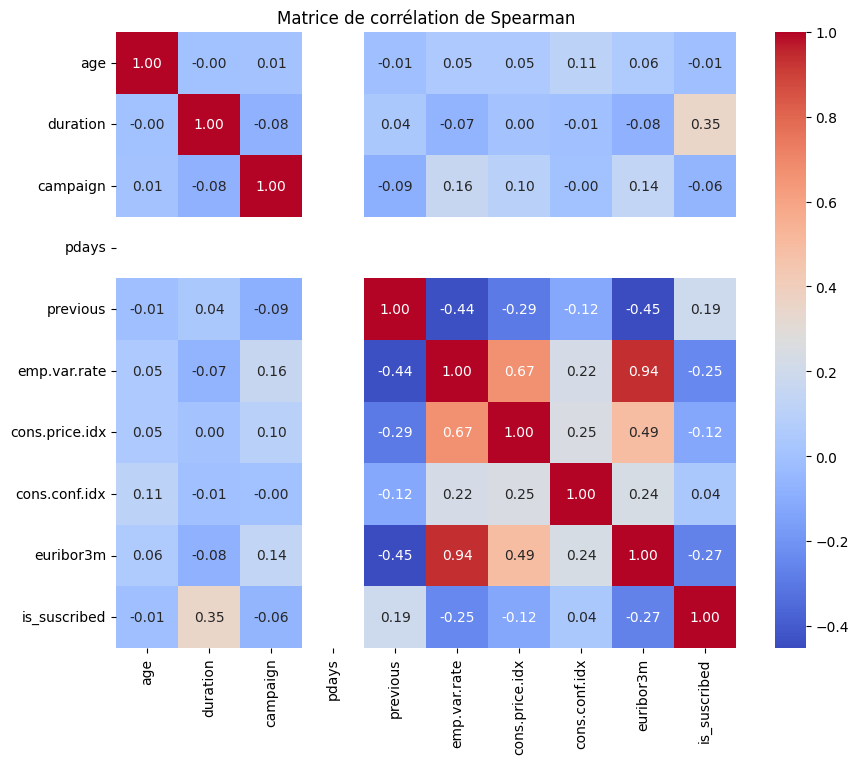

In [241]:
plt.figure(figsize=(10, 8))
corr = df_clean[numeric_cols+["is_suscribed"]].corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation de Spearman")
plt.show()

Podemos ver una gran correlacion entre euribor3m y emp.var.rate lo que reprensenta multicolinealidad asi vamos a quitar la variable emp.var.rate. La variable cons.price.idx y emp.var.rate tienen tambien una correlacion considerable. 

In [242]:
df_clean = df_clean.drop(columns=['emp.var.rate'])

In [243]:
corr["is_suscribed"].sort_values(ascending=False)

is_suscribed      1.000000
duration          0.348320
previous          0.193522
cons.conf.idx     0.041053
age              -0.013309
campaign         -0.063517
cons.price.idx   -0.124092
emp.var.rate     -0.247107
euribor3m        -0.266208
pdays                  NaN
Name: is_suscribed, dtype: float64

Frente a la variable objetiva, no tenemos una gran correlacion lineal. Podemos ver de nuevo la importancia de la variable Duration con un score de correlacion de 0.35 (la mayor aqui). Para la variable pdays, con la windsorizacion tenemos solo una unica valor asi no es tan importante guardarla. Pero quiero tranformarla en variable categorica 1 si hubo dias transcurido desde el ultimo contacto y 0 si no.

In [244]:
df_clean['pdays'] = df_clean['pdays'].apply(lambda x: 1 if x > 0 else 0)
str_cols.append('pdays')


## CHI 2

In [ ]:
# tu codigo
def chi_square_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    return chi2, p
def analyze_categorical_relationships(df, categorical_cols):
    results = []
    for i in range(len(categorical_cols)):
        for j in range(i + 1, len(categorical_cols)):
            col1 = categorical_cols[i]
            col2 = categorical_cols[j]
            chi2, p = chi_square_test(df, col1, col2)
            results.append((col1, col2, chi2, p))
    return results

categorical_relationships = analyze_categorical_relationships(df_clean, str_cols)
results_df = pd.DataFrame(categorical_relationships, columns=['col1', 'col2', 'chi2', 'p-value'])
results_df['significant'] = results_df['p-value'] < 0.05

results_df['p-value'] = results_df['p-value'].apply(lambda x: '{:.2e}'.format(x))
results_df['chi2'] = results_df['chi2'].apply(lambda x: '{:.2f}'.format(x))
results_df['chi2'] = results_df['chi2'].astype('float')
results_df.sort_values(by='chi2', ascending=False, inplace=True)
pd.set_option('display.max_rows', None)
results_df

col1          col2       chi2    p-value  significant
65         month   nr.employed  165145.79   0.00e+00         True
1            job     education   34309.80   0.00e+00         True
60       contact   nr.employed   18768.71   0.00e+00         True
57       contact         month   15286.32   0.00e+00         True
72      poutcome   nr.employed   15019.28   0.00e+00         True
75   nr.employed  is_suscribed    6971.81   0.00e+00         True
9            job   nr.employed    5221.28   0.00e+00         True
64         month      poutcome    4858.49   0.00e+00         True
6            job         month    4565.10   0.00e+00         True
73      poutcome  is_suscribed    4230.14   0.00e+00         True
0            job       marital    4080.71   0.00e+00         True
66         month  is_suscribed    3103.03   0.00e+00         True
59       contact      poutcome    2423.00   0.00e+00         True
27     education         month    2354.87   0.00e+00         True
39       default   nr.employed    2253.67   0.00e+00         True
23     education       default    2046.38   0.00e+00         True
2            job       default    1926.75   0.00e+00         True
12       marital     education    1612.73   0.00e+00         True
30     education   nr.employed    1497.53  1.75e-273         True
36       default         month    1049.89  1.52e-211         True
10           job  is_suscribed     961.74  3.27e-199         True
61       contact  is_suscribed     862.08  1.72e-189         True
8            job      poutcome     838.80  3.41e-163         True
63         month   day_of_week     766.25  9.94e-138         True
35       default       contact     759.01  1.53e-165         True
13       marital       default     749.41  6.94e-161         True
20       marital   nr.employed     685.28  2.87e-132         True
5            job       contact     684.08  1.39e-139         True
26     education       contact     532.33  9.09e-112         True
38       default      poutcome     487.94  2.71e-104         True
69   day_of_week   nr.employed     459.27   1.21e-72         True
40       default  is_suscribed     406.56   5.22e-89         True
17       marital         month     324.55   4.21e-58         True
47       housing   nr.employed     250.00   5.42e-48         True
43       housing       contact     249.23   3.82e-56         True
16       marital       contact     215.50   1.60e-47         True
44       housing         month     203.89   5.06e-39         True
31     education  is_suscribed     191.91   1.00e-38         True
29     education      poutcome     159.57   6.43e-28         True
58       contact   day_of_week     128.31   8.96e-27         True
21       marital  is_suscribed     121.09   5.08e-27         True
19       marital      poutcome     109.51   9.26e-23         True
7            job   day_of_week      88.37   8.28e-05         True
28     education   day_of_week      74.38   4.66e-07         True
42       housing          loan      54.35   1.68e-13         True
70   day_of_week  is_suscribed      26.05   3.09e-05         True
46       housing      poutcome      26.04   2.21e-06         True
68   day_of_week      poutcome      25.51   1.27e-03         True
4            job          loan      22.85   1.86e-02         True
54          loan   nr.employed      22.78   1.16e-02         True
18       marital   day_of_week      20.85   7.55e-03         True
3            job       housing      19.96   4.60e-02         True
51          loan         month      19.35   2.24e-02         True
37       default   day_of_week      18.49   1.78e-02         True
45       housing   day_of_week      17.65   1.45e-03         True
24     education       housing      16.19   1.28e-02         True
33       default       housing       8.97   1.13e-02         True
14       marital       housing       8.76   1.26e-02         True
50          loan       contact       7.31   6.84e-03         True
52          loan   day_of_week       6.14   1.89e-01

Las variables housing y loan no estan tan significativas frente a nuetra variable objetiva asi podemos eliminarlas de nuestro dataset final para hacer nuestro modelo de prediccion. Y tambien la variable pdays no sirve a bien predecir la target asi la quito.

In [ ]:
def cramers_v(x, y):
    """
    Calcula Cramér's V para dos variables categóricas.
    
    Parámetros:
    - x, y: Series o arrays de pandas que representan variables categóricas.
    
    Retorna:
    - Valor de Cramér's V, entre 0 y 1.
    """
    tabla_cruzada = pd.crosstab(x, y)

    chi2, p, dof, expected = chi2_contingency(tabla_cruzada)
    
    n = tabla_cruzada.sum().sum()
    min_dim = min(tabla_cruzada.shape) - 1
    if min_dim == 0:
        return np.nan 
    
    return np.sqrt(chi2 / (n * min_dim))


cramers_v_results = []
for i in range(len(str_cols)):
    for j in range(i + 1, len(str_cols)):
        col1 = str_cols[i]
        col2 = str_cols[j]
        cv = cramers_v(df_clean[col1], df_clean[col2])
        cramers_v_results.append((col1, col2, cv))
cramers_v_df = pd.DataFrame(cramers_v_results, columns=['col1', 'col2', 'Cramér\'s V'])
cramers_v_df['Cramér\'s V'] = cramers_v_df['Cramér\'s V'].apply(lambda x: '{:.2f}'.format(x))
cramers_v_df.sort_values(by='Cramér\'s V', ascending=False, inplace=True)
cramers_v_df.head(60)

col1          col2 Cramér's V
77  is_suscribed         pdays        nan
67         month         pdays        nan
41       default         pdays        nan
49       housing         pdays        nan
56          loan         pdays        nan
62       contact         pdays        nan
22       marital         pdays        nan
11           job         pdays        nan
71   day_of_week         pdays        nan
74      poutcome         pdays        nan
76   nr.employed         pdays        nan
32     education         pdays        nan
60       contact   nr.employed       0.68
65         month   nr.employed       0.67
57       contact         month       0.61
72      poutcome   nr.employed       0.43
75   nr.employed  is_suscribed       0.41
1            job     education       0.37
73      poutcome  is_suscribed       0.32
66         month  is_suscribed       0.27
64         month      poutcome       0.24
59       contact      poutcome       0.24
0            job       marital       0.22
39       default   nr.employed       0.17
23     education       default       0.16
10           job  is_suscribed       0.15
2            job       default       0.15
61       contact  is_suscribed       0.14
12       marital     education       0.14
35       default       contact       0.14
5            job       contact       0.13
9            job   nr.employed       0.11
6            job         month       0.11
26     education       contact       0.11
36       default         month       0.11
13       marital       default       0.10
8            job      poutcome       0.10
40       default  is_suscribed       0.10
27     education         month       0.10
20       marital   nr.employed       0.09
38       default      poutcome       0.08
30     education   nr.employed       0.08
43       housing       contact       0.08
47       housing   nr.employed       0.08
31     education  is_suscribed       0.07
16       marital       contact       0.07
63         month   day_of_week       0.07
44       housing         month       0.07
17       marital         month       0.06
58       contact   day_of_week       0.06
69   day_of_week   nr.employed       0.05
21       marital  is_suscribed       0.05
42       housing          loan       0.04
19       marital      poutcome       0.04
29     education      poutcome       0.04
46       housing      poutcome       0.03
70   day_of_week  is_suscribed       0.03
54          loan   nr.employed       0.02
7            job   day_of_week       0.02
24     education       housing       0.02

Aqui vemos muchas cosas. Primero, podemos ver que las variables con un V de Cramer muy alto son contact y nr.employed y month y nr.employed. Eso nos permite ver que hay una relacion entre esas variables. Lo notamos cuando haremos nuestro modelo. \
La variable que tiene el mayor V de Cramer con nuestra variable objetiva es el nr.employed. Hemos visto que hay empleados muy eficientes y otros que hacen una grand cantitad de tratamiento de clientes.\
Por fin, tenemos variables con muy pequenos V de Cramer y los que llama mi atencion son default y el contact. Como hemos vistos del problema sobre default, quiero quitarla ahora porque no aporta mucho a la variable objetiva.

## T-TEST

In [ ]:
def t_student(gp1, gp2):
    stat, p = ttest_ind(gp1, gp2)

    print(f"Statistique de test : {stat:.3f}")
    print(f"P-value : {p:.3f}")

    
    if p < 0.05:
        print("Diferencia significativa entre los grupos.")
    else:
        print("Ninguna diferencia significativa entre los grupos.")
        return None


In [ ]:
group1_age = df_clean[df_clean['is_suscribed'] == 0]['age']
group2_age = df_clean[df_clean['is_suscribed'] == 1]['age']

t_student(group1_duration, group2_duration)


Statistique de test : 0.277
P-value : 0.782
Ninguna diferencia significativa entre los grupos.


In [249]:
group1_previous = df_clean[df_clean['is_suscribed'] == 0]['previous']
group2_previous = df_clean[df_clean['is_suscribed'] == 1]['previous']
t_student(group1_previous, group2_previous)

Statistique de test : -40.025
P-value : 0.000
Diferencia significativa entre los grupos.


In [250]:
group1_previous = df_clean[df_clean['contact'] == "cellular"]['age']
group2_previous = df_clean[df_clean['contact'] == "telephone"]['age']
t_student(group1_previous, group2_previous)

Statistique de test : -4.767
P-value : 0.000
Diferencia significativa entre los grupos.


La variable previous tiene un efecto significativo sobre la variable target. Pero al contrario la edad no tiene un relacion con la target asi se puede quitarla.

## MUTUAL INFORMATION

In [256]:
df_selection = df_raw.copy()

In [ ]:
# un parte es tu codigo y el uso del one hot encoder lo usamos con jesus
target_encoder = TargetEncoder()
df_selection['is_suscribed'] = df_selection['is_suscribed'].astype(int)
df_selection['month'] = target_encoder.fit_transform(df_selection[['month']], df_selection['is_suscribed'])
df_selection['nr.employed'] = target_encoder.fit_transform(df_selection[['nr.employed']], df_selection['is_suscribed'])
str_cols_dummies = [col for col in str_cols if col not in ['month', 'nr.employed',"is_suscribed"]]
encoder = OneHotEncoder(sparse_output =False,handle_unknown='ignore')
encoded_array = encoder.fit_transform(df_selection[str_cols_dummies])
df_dummies = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(str_cols_dummies))
df_selection = pd.concat([df_selection.drop(columns=str_cols_dummies), df_dummies], axis=1)
df_selection

In [ ]:
X = df_selection.drop(columns=["is_suscribed"])
y = df_selection["is_suscribed"]
mi_scores = mutual_info_classif(X, y, random_state=42)

mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

mi_series_grouped = mi_series.groupby(lambda x: x.split('-')[0]).sum().reset_index()
mi_series_grouped['type_column'] = mi_series_grouped['index'].apply(
    lambda col: 'numeric' if col in numeric_cols else 'categorical' if col in str_cols else 'other'
)
mi_series_grouped.sort_values(by=0, ascending=False).reset_index(drop=True).rename(columns={'index': 'col_name', 0: 'importance'}).style.background_gradient(cmap='coolwarm')


'X = df_selection.drop(columns=["is_suscribed"])\ny = df_selection["is_suscribed"]\nmi_scores = mutual_info_classif(X, y, random_state=42)\n\nmi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)\n\nmi_series_grouped = mi_series.groupby(lambda x: x.split(\'-\')[0]).sum().reset_index()\nmi_series_grouped[\'type_column\'] = mi_series_grouped[\'index\'].apply(\n    lambda col: \'numeric\' if col in numeric_cols else \'categorical\' if col in str_cols else \'other\'\n)\nmi_series_grouped.sort_values(by=0, ascending=False).reset_index(drop=True).rename(columns={\'index\': \'col_name\', 0: \'importance\'}).style.background_gradient(cmap=\'coolwarm\')\n'

Parece que las variables education, el job y el status marital y el dia de la semana no están relacionadas con la variable objetivo, lo que muy probablemente no tengan capacidad predictiva. Podemos eliminarlas en el futuro pero podra ser interesente guardarlas en nuestro modelo baseline.

In [254]:
df_clean = df_clean.drop(columns=['housing',"loan","default","pdays","age"])
str_cols.remove('housing')
str_cols.remove('loan')
str_cols.remove('default')
str_cols.remove('pdays')
numeric_cols.remove('age')

# FINAL

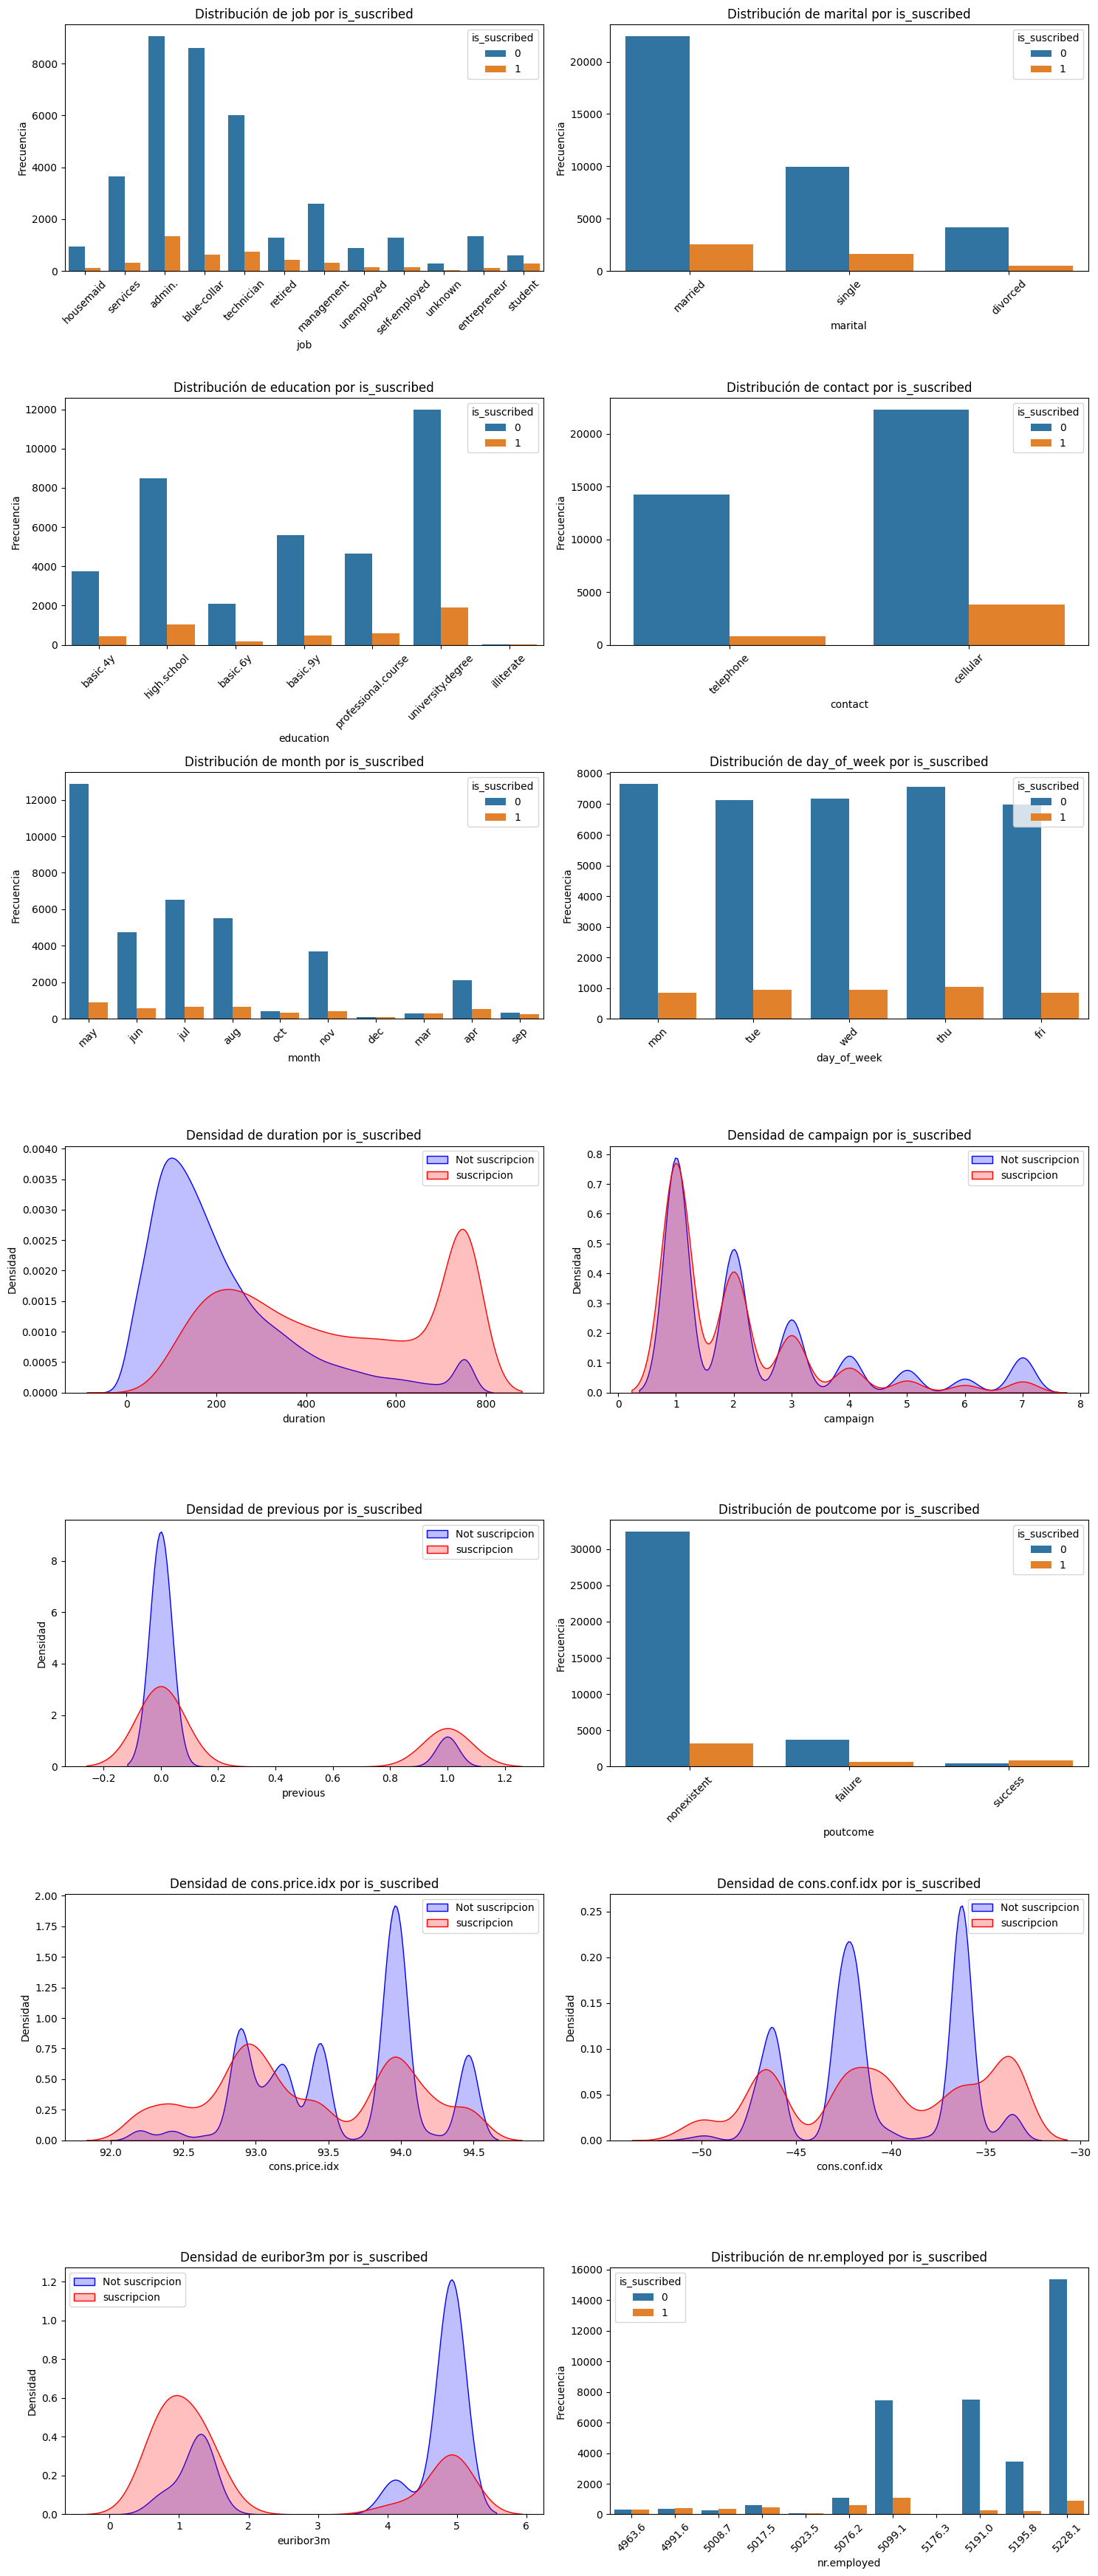

In [ ]:

X = df_clean.drop(columns=['is_suscribed']) 
y = df_clean['is_suscribed'] 


fig, axs = plt.subplots(nrows=(len(X.columns) + 1) // 2, ncols=2, figsize=(15, 5 * ((len(X.columns) + 1) // 2)))

for i, column in enumerate(X.columns):
    row = i // 2
    col = i % 2
    if X[column].dtype == 'object':
        sns.countplot(data=df_clean, x=column, hue='is_suscribed', ax=axs[row, col])
        axs[row, col].set_title(f'Distribución de {column} por is_suscribed')
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel('Frecuencia')
        axs[row, col].tick_params(axis='x', rotation=45)
        axs[row, col].legend(title='is_suscribed')
    elif X[column].dtype in ['int64', 'float64']:
        sns.kdeplot(data=df_clean[df_clean['is_suscribed'] == 0], x=column, label='Not suscripcion', fill=True, ax=axs[row, col], color='blue')
        sns.kdeplot(data=df_clean[df_clean['is_suscribed'] == 1], x=column, label='suscripcion', fill=True, ax=axs[row, col], color='red')
        axs[row, col].set_title(f'Densidad de {column} por is_suscribed')
        axs[row, col].set_xlabel(column)
        axs[row, col].set_ylabel('Densidad')
        axs[row, col].legend()


for j in range(i + 1, len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

Podemos decir que hay variables como Housing, Loan, Default, Pdays y Age que no sirven para nuestro modelo porque no tienen una relación significativa con nuestra variable objetivo.\
\
Hemos visto que el día de la semana no nos ayuda en la predicción de la variable final, según la información mutua. Lo mismo ocurre con la educación, el trabajo y el estado civil, pero conservamos estas variables para evaluar su capacidad predictiva en el modelo.\
\
Parece que un contacto a través del celular tiene más probabilidades de éxito, pero hemos comprobado que esto no se justifica con la edad.\
\
El mes del último contacto parece influir en el éxito de la campaña. Podemos observar que entre abril y agosto son los meses más importantes para el negocio.\

Hemos demostrado que la duración de la llamada es un factor clave y que, en general, una llamada de menos de 200 segundos no suele ser exitosa.\
\
El número de llamadas realizadas durante la última campaña no tiene una gran correlación con la variable objetivo. Se podría considerar eliminarla, pero la mantenemos en el modelo baseline para evaluar su poder predictivo.\
\
El número de llamadas realizadas anteriormente sí tiene un impacto en la variable objetivo.\
\
La variable poutcome, que indica el éxito o fracaso de la campaña previa, muestra que si una persona tuvo éxito en la campaña anterior, es mucho más probable que tenga éxito en esta. Por lo tanto, tiene un fuerte poder predictivo. De hecho, es la mejor variable según el coeficiente V de Cramer, después de nr.employed.\
\
Las variables cons.price.idx y cons.conf.idx no tienen una gran correlación con la variable objetivo. Las mantenemos para evaluar si es conveniente eliminarlas o no al predecir con un modelo baseline.\
\
Euribor3m es la variable con la mayor correlación con la variable objetivo.\
\
Por último, hemos visto que el éxito de una suscripción depende del empleado que realiza la llamada. También hay empleados que tienen una mayor eficiencia.